In [1]:
import torch
import torch.nn.functional as F
import pandas
import torchaudio
import torchaudio.transforms as T
import os
from datasets import load_dataset,Audio
import numpy as np
import soundata
from torch.utils.data import Dataset, DataLoader
from ..src.utils.datasets import UrbanSound8k
#from sklearn.model_selection import train_test_split
torchaudio.set_audio_backend("soundfile")

In [2]:
from torchmetrics import Metric
from torch import Tensor
class ExpectedCost(Metric):
    """
    Wrapper on the expected cost as defined in https://github.com/luferrer/expected_cost
    """
    def __init__(self,task = "binary", costs=None, priors=None, sample_weight=None, adjusted=False,num_classes = 2):
        super().__init__()
        self.conf = ConfusionMatrix(task=task,num_classes=num_classes)
        if costs is None:
            
            costs = 1-torch.eye(num_classes)
            
            self.costs = costs
        else:
            self.costs = costs
        self.priors = priors
        self.sample_weight = sample_weight
        self.adjusted=adjusted
        self.num_classes = num_classes
        
            
        self.add_state("bincounts", default=torch.zeros(num_classes), dist_reduce_fx="sum")
        self.add_state("matrix", default=torch.zeros((num_classes,num_classes)), dist_reduce_fx="sum")
        
    def _input_format(self,preds,target):
        return preds,target
    def update(self, preds: Tensor, target: Tensor):
        preds, target = self._input_format(preds, target)
        
        assert preds.shape == target.shape
        self.matrix = self.conf(preds,target)
        
        self.bincounts = torch.bincount(target,minlength=self.num_classes)
        
    def compute(self):
        self.matrix = self.matrix/self.matrix.sum(axis=1, keepdims=True)
        priors = (self.bincounts/self.bincounts.sum()).unsqueeze(0).T
        if self.adjusted:
            # When adjusted is true, normalize the average cost
            # with the cost of a naive system that always makes
            # the min cost decision.
            norm_value = torch.min(torch.dot(priors.T, self.costs))
        else:
            norm_value = 1.0
                
        ave_cost = torch.sum(priors * self.costs * self.matrix)

        return ave_cost / norm_value

In [4]:
dataset_train = UrbanSound8k(mode="train")

100%|██████████| 8732/8732 [06:40<00:00, 21.79it/s]


In [5]:
dataset_valid = UrbanSound8k(mode="validation")

100%|██████████| 8732/8732 [01:56<00:00, 74.95it/s]   


In [6]:
177080-150000

27080

In [4]:
dataset_test = UrbanSound8k(mode="test")

100%|██████████| 8732/8732 [01:28<00:00, 98.25it/s]   


## Load NMF-based multilabel segmentation model

In [5]:
import yaml
from pyannote.audio import Model

w_nmf = torch.load("/lium/raid01_b/tmario/phD/JSALT2023/src/1.explainability/nmf/dict/W_win_1024_nfft_1024_256_beta_2_mu_1_AragonRadio_sp_200_mus_500_no_500_max_seg_4.pt")
with open("/lium/raid01_b/tmario/phD/JSALT2023/src/1.explainability/nmf/config_wavlm.yaml","rb") as fh:
    cfg = yaml.safe_load(fh)
model = Model.from_pretrained("/lium/raid01_b/tmario/phD/JSALT2023/src/1.explainability/nmf/3MASNMF/make_it_sparser_256/X.Segmentation.Full_WP2-make_it_sparser_256-10.0-5.0-0.1-augTrue/models/23_12_12.ckpt",
                              w_nmf=w_nmf,
                              wavlm_cfg=cfg["model"]["wavlm"],
                              spec_kw={"win_length":1024, "hop_length":320,"n_fft":1024})
model.freeze()

Type of NMF matrix: <class 'torch.Tensor'> torch.Size([513, 256])


Using cache found in /lium/home/mlebour/.cache/torch/hub/s3prl_s3prl_main
INFO: Requesting URL: https://huggingface.co/s3prl/converted_ckpts/resolve/main/wavlm_large.pt
INFO: Using URL's local file: /lium/home/mlebour/.cache/s3prl/download/f2d5200177fd6a33b278b7b76b454f25cd8ee866d55c122e69fccf6c7467d37d.wavlm_large.pt
INFO: WavLM Config: {'extractor_mode': 'layer_norm', 'encoder_layers': 24, 'encoder_embed_dim': 1024, 'encoder_ffn_embed_dim': 4096, 'encoder_attention_heads': 16, 'activation_fn': 'gelu', 'layer_norm_first': True, 'conv_feature_layers': '[(512,10,5)] + [(512,3,2)] * 4 + [(512,2,2)] * 2', 'conv_bias': False, 'feature_grad_mult': 1.0, 'normalize': True, 'dropout': 0.0, 'attention_dropout': 0.0, 'activation_dropout': 0.0, 'encoder_layerdrop': 0.0, 'dropout_input': 0.0, 'dropout_features': 0.0, 'mask_length': 10, 'mask_prob': 0.8, 'mask_selection': 'static', 'mask_other': 0.0, 'no_mask_overlap': False, 'mask_min_space': 1, 'mask_channel_length': 10, 'mask_channel_prob': 0.0,

### Classifier instance

In [10]:
class Probe(torch.nn.Module):
    
    def __init__(self,input_size=256,hidden_size=128,output_size=2):
        super().__init__()
        self.probe = torch.nn.Sequential(torch.nn.Linear(2*input_size,hidden_size),
                            torch.nn.ReLU(),
                            torch.nn.Linear(hidden_size,output_size))
        
    def forward(self,x):
        x_mean = x.mean(dim=1)
        x_std = x.std(dim=1)
        
        y = self.probe(torch.cat([x_mean,x_std],dim=-1))
        
        return y
        
        

In [8]:
class LinProbe(torch.nn.Module):
    
    def __init__(self,input_size=256,output_size=10):
        super().__init__()
        self.probe = torch.nn.Sequential(torch.nn.Linear(2*input_size,output_size))
    
    def forward(self,x):
        x_mean = x.mean(dim=1)
        x_std = x.std(dim=1)
        
        y = self.probe(torch.cat([x_mean,x_std],dim=-1))
        
        return y

In [6]:
class LinProbe(torch.nn.Module):
    
    def __init__(self,input_size=256,output_size=10,agreg = "mean_std"):
        super().__init__()
        self.agreg = agreg
        weight = 1 if agreg in ["mean","std"] else 2
        
        self.probe = torch.nn.Sequential(torch.nn.Linear(weight*input_size,output_size))
    
    def forward(self,x):
        x_mean = None
        x_std = None
        if "mean" in self.agreg:
            x_mean = x.mean(dim=1)
        if "std" in self.agreg:
            x_std = x.std(dim=1)
        if x_mean is not None and x_std is not None:
            input_x = torch.cat([x_mean,x_std],dim=-1)
        elif x_mean is not None:
            input_x = x_mean
        elif x_std is not None:
            input_x = x_std
        
        y = self.probe(input_x)
        
        return y

In [15]:


def train_epoch(seg_model,classif_probe,dataloader,loss_fun,optimizer,device="cpu"):
    avg_loss=0
    last_avg_loss=0
    for batch_idx, (data,label) in enumerate(tqdm.tqdm(dataloader)):    
        optimizer.zero_grad()
        
        with torch.no_grad():
            feat = seg_model.wavlm(data.to(device))
            emb = seg_model.emb_transform(feat)
        
        logits = classif_probe(emb.permute(0,2,1))
        
        loss = loss_fun(logits,label.to(device))
        loss.backward()
        optimizer.step()
        
        avg_loss += loss
        
        if batch_idx%10 == 0:
            avg_loss/=10
            last_avg_loss=avg_loss
            print(f"Train loss: {avg_loss}")
            avg_loss=0
        
    return classif_probe, last_avg_loss

def valid_epoch(seg_model,classif_probe,dataloader,loss_fun,device="cpu"):
    valid_loss=0.0
    for batch_idx, (data, label) in enumerate(tqdm.tqdm(dataloader,desc="Validation")):        
        
        with torch.no_grad():
            feat = seg_model.wavlm(data.to(device))
            emb = seg_model.emb_transform(feat)
        
        logits = classif_probe(emb.permute(0,2,1))   
        
        valid_loss += loss_fun(logits,label.to(device))
        
    return valid_loss/(batch_idx+1)

In [16]:
n_epoch = 50

classif_probe = LinProbe(input_size=256,output_size=10)

train_loader= DataLoader(dataset_train, batch_size=128, shuffle=True,num_workers=10)
valid_loader = DataLoader(dataset_valid, batch_size=128, shuffle=False,num_workers=10)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classif_probe.parameters(),lr=0.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
classif_probe.to(device)

best_valid = 1e8

train_loss = []
valid_loss = []
for epoch in range(1,n_epoch+1):
    print(f"Epoch {epoch}")
    classif_probe, train_loss_t = train_epoch(seg_model=model,classif_probe=classif_probe,dataloader=train_loader,loss_fun=loss_fn,optimizer=optimizer,device=device)
    valid_loss_t = valid_epoch(seg_model=model,classif_probe=classif_probe,dataloader=valid_loader,loss_fun=loss_fn,device=device)
    valid_loss.append(valid_loss_t)
    print(f"Validation loss = {valid_loss}")
    
    train_loss.append(train_loss_t)
    
    
    if valid_loss_t < best_valid:
        torch.save(classif_probe.state_dict(), "noise_probe.pt")
        best_valid = valid_loss_t
    

Epoch 1


  2%|▏         | 1/43 [00:03<02:15,  3.24s/it]

Train loss: 0.22963599860668182


 26%|██▌       | 11/43 [00:26<01:13,  2.31s/it]

Train loss: 2.1946334838867188


 49%|████▉     | 21/43 [00:49<00:51,  2.32s/it]

Train loss: 2.059309244155884


 72%|███████▏  | 31/43 [01:12<00:27,  2.32s/it]

Train loss: 1.9831699132919312


 95%|█████████▌| 41/43 [01:35<00:04,  2.33s/it]

Train loss: 1.920479655265808


Validation: 100%|██████████| 13/13 [00:30<00:00,  2.38s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>)]
Epoch 2


  2%|▏         | 1/43 [00:03<02:18,  3.29s/it]

Train loss: 0.18422508239746094


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.9045082330703735


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.8277744054794312


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.8405752182006836


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.8356355428695679


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>)]
Epoch 3


  2%|▏         | 1/43 [00:03<02:18,  3.31s/it]

Train loss: 0.18587937951087952


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.8003383874893188


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.7763996124267578


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.784563422203064


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.7658370733261108


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>)]
Epoch 4


  2%|▏         | 1/43 [00:03<02:18,  3.30s/it]

Train loss: 0.17814044654369354


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.757231593132019


 49%|████▉     | 21/43 [00:50<00:51,  2.35s/it]

Train loss: 1.7166355848312378


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.7584341764450073


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.7275686264038086


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>)]
Epoch 5


  2%|▏         | 1/43 [00:03<02:18,  3.30s/it]

Train loss: 0.17041976749897003


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.7172060012817383


 49%|████▉     | 21/43 [00:50<00:51,  2.35s/it]

Train loss: 1.729583978652954


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.6972439289093018


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.6920645236968994


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>)]
Epoch 6


  2%|▏         | 1/43 [00:03<02:20,  3.34s/it]

Train loss: 0.1688179224729538


 26%|██▌       | 11/43 [00:26<01:15,  2.36s/it]

Train loss: 1.7293814420700073


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.6570895910263062


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.6522330045700073


 95%|█████████▌| 41/43 [01:37<00:04,  2.34s/it]

Train loss: 1.7095240354537964


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>)]
Epoch 7


  2%|▏         | 1/43 [00:03<02:17,  3.27s/it]

Train loss: 0.17219679057598114


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.6636637449264526


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.6575084924697876


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.7001246213912964


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.650368571281433


Validation: 100%|██████████| 13/13 [00:30<00:00,  2.38s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>)]
Epoch 8


  2%|▏         | 1/43 [00:03<02:19,  3.32s/it]

Train loss: 0.17755645513534546


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.6330267190933228


 49%|████▉     | 21/43 [00:50<00:51,  2.35s/it]

Train loss: 1.6412609815597534


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.6360327005386353


 95%|█████████▌| 41/43 [01:37<00:04,  2.34s/it]

Train loss: 1.6842520236968994


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>)]
Epoch 9


  2%|▏         | 1/43 [00:03<02:17,  3.28s/it]

Train loss: 0.16134250164031982


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.6359026432037354


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.6397974491119385


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.6350994110107422


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.6394081115722656


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>)]
Epoch 10


  2%|▏         | 1/43 [00:03<02:21,  3.36s/it]

Train loss: 0.15551285445690155


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.6069004535675049


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.6692167520523071


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.6035349369049072


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.6211931705474854


Validation: 100%|██████████| 13/13 [00:30<00:00,  2.38s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>)]
Epoch 11


  2%|▏         | 1/43 [00:03<02:17,  3.28s/it]

Train loss: 0.16119986772537231


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.6324704885482788


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.5746382474899292


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.644989252090454


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.61981999874115


Validation: 100%|██████████| 13/13 [00:30<00:00,  2.38s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>)]
Epoch 12


  2%|▏         | 1/43 [00:03<02:18,  3.29s/it]

Train loss: 0.17037630081176758


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.6096245050430298


 49%|████▉     | 21/43 [00:50<00:51,  2.35s/it]

Train loss: 1.5761619806289673


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.6513267755508423


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.550737738609314


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>)]
Epoch 13


  2%|▏         | 1/43 [00:03<02:19,  3.33s/it]

Train loss: 0.16286616027355194


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.5941303968429565


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.5952720642089844


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.592124342918396


 95%|█████████▌| 41/43 [01:37<00:04,  2.34s/it]

Train loss: 1.5719668865203857


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>)]
Epoch 14


  2%|▏         | 1/43 [00:03<02:19,  3.33s/it]

Train loss: 0.1697513461112976


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.581934928894043


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.587936282157898


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.5627248287200928


 95%|█████████▌| 41/43 [01:37<00:04,  2.34s/it]

Train loss: 1.5864055156707764


Validation: 100%|██████████| 13/13 [00:30<00:00,  2.38s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>)]
Epoch 15


  2%|▏         | 1/43 [00:03<02:21,  3.36s/it]

Train loss: 0.16312064230442047


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.5487583875656128


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.567255973815918


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.558066964149475


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.5946518182754517


Validation: 100%|██████████| 13/13 [00:30<00:00,  2.38s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>)]
Epoch 16


  2%|▏         | 1/43 [00:03<02:19,  3.31s/it]

Train loss: 0.16156090795993805


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.5474499464035034


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.5741876363754272


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.5732816457748413


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.5561789274215698


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>)]
Epoch 17


  2%|▏         | 1/43 [00:03<02:18,  3.30s/it]

Train loss: 0.16802679002285004


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.5555148124694824


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.5721535682678223


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.5386600494384766


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.5224298238754272


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.38s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>)]
Epoch 18


  2%|▏         | 1/43 [00:03<02:18,  3.31s/it]

Train loss: 0.14633560180664062


 26%|██▌       | 11/43 [00:26<01:15,  2.36s/it]

Train loss: 1.5848793983459473


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.5737706422805786


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.5478756427764893


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.5037411451339722


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:19,  3.31s/it]

Train loss: 0.16633567214012146


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.5118359327316284


 49%|████▉     | 21/43 [00:50<00:51,  2.35s/it]

Train loss: 1.5442190170288086


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.5300302505493164


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.5508214235305786


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:18,  3.29s/it]

Train loss: 0.14177076518535614


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.5470167398452759


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.547237515449524


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.511709451675415


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.5399945974349976


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:19,  3.32s/it]

Train loss: 0.1639644354581833


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.5623958110809326


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.514320969581604


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.562097191810608


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.4788068532943726


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:17,  3.28s/it]

Train loss: 0.1608469933271408


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.5210984945297241


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.5228439569473267


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.5521587133407593


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.4861947298049927


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:17,  3.27s/it]

Train loss: 0.14578793942928314


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.4910802841186523


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.5392411947250366


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.4943889379501343


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.5398733615875244


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:19,  3.33s/it]

Train loss: 0.14942382276058197


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.5442475080490112


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.5077729225158691


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.4958606958389282


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.4949774742126465


Validation: 100%|██████████| 13/13 [00:30<00:00,  2.38s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:19,  3.31s/it]

Train loss: 0.14983338117599487


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.5073617696762085


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.532566785812378


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.4726325273513794


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.4936141967773438


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:17,  3.28s/it]

Train loss: 0.15004561841487885


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.510779619216919


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.4906628131866455


 72%|███████▏  | 31/43 [01:13<00:28,  2.33s/it]

Train loss: 1.490073561668396


 95%|█████████▌| 41/43 [01:36<00:04,  2.33s/it]

Train loss: 1.4767788648605347


Validation: 100%|██████████| 13/13 [00:30<00:00,  2.38s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:20,  3.35s/it]

Train loss: 0.1447943150997162


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.4961589574813843


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.487730860710144


 72%|███████▏  | 31/43 [01:13<00:28,  2.33s/it]

Train loss: 1.4575475454330444


 95%|█████████▌| 41/43 [01:36<00:04,  2.33s/it]

Train loss: 1.5122888088226318


Validation: 100%|██████████| 13/13 [00:30<00:00,  2.38s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:18,  3.30s/it]

Train loss: 0.14966261386871338


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.501965880393982


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.4976168870925903


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.4605910778045654


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.4785256385803223


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:18,  3.29s/it]

Train loss: 0.15284192562103271


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.459713101387024


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.4985109567642212


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.4873420000076294


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.4695196151733398


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]  3.28s/it]

Train loss: 1.4643501043319702


 95%|█████████▌| 41/43 [01:37<00:04,  2.34s/it]

Train loss: 1.5175366401672363


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:19,  3.32s/it]

Train loss: 0.14962278306484222


 26%|██▌       | 11/43 [00:26<01:15,  2.36s/it]

Train loss: 1.46675443649292


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.4754732847213745


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.4523247480392456


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.4666345119476318


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:17,  3.27s/it]

Train loss: 0.1499914675951004


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.4874591827392578


 49%|████▉     | 21/43 [00:50<00:51,  2.35s/it]

Train loss: 1.430148720741272


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.4519777297973633


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.4898055791854858


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:19,  3.33s/it]

Train loss: 0.15269501507282257


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.4555573463439941


 49%|████▉     | 21/43 [00:50<00:51,  2.35s/it]

Train loss: 1.4525941610336304


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.4581283330917358


 95%|█████████▌| 41/43 [01:37<00:04,  2.34s/it]

Train loss: 1.4556857347488403


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:18,  3.31s/it]

Train loss: 0.1468781679868698


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.532588005065918


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.4000627994537354


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.4362882375717163


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.435814619064331


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:20,  3.36s/it]

Train loss: 0.1415739506483078


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.4432684183120728


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.4352790117263794


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.474583625793457


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.445471167564392


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:18,  3.31s/it]

Train loss: 0.14906711876392365


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.416021704673767


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.4153515100479126


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.4655460119247437


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.476906180381775


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:17,  3.26s/it]

Train loss: 0.1449664831161499


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.4256243705749512


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.4519456624984741


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.4284895658493042


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.458308219909668


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:18,  3.29s/it]

Train loss: 0.12812593579292297


 26%|██▌       | 11/43 [00:26<01:15,  2.36s/it]

Train loss: 1.4523085355758667


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.4409822225570679


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.4297090768814087


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.4333100318908691


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:20,  3.35s/it]

Train loss: 0.15172038972377777


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.4124515056610107


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.4357101917266846


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.4184902906417847


 95%|█████████▌| 41/43 [01:37<00:04,  2.34s/it]

Train loss: 1.46998929977417


Validation: 100%|██████████| 13/13 [00:30<00:00,  2.38s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:31,  3.60s/it]

Train loss: 0.14490391314029694


 26%|██▌       | 11/43 [00:27<01:15,  2.35s/it]

Train loss: 1.430475115776062


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.4525331258773804


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.4062328338623047


 95%|█████████▌| 41/43 [01:37<00:04,  2.34s/it]

Train loss: 1.4195877313613892


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:20,  3.35s/it]

Train loss: 0.14452426135540009


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.3983161449432373


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.4132343530654907


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.4200239181518555


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.4510973691940308


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:20,  3.34s/it]

Train loss: 0.13751496374607086


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.3980717658996582


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.470566987991333


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.429348111152649


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.3799002170562744


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:18,  3.30s/it]

Train loss: 0.1458723545074463


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.4095004796981812


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.4331294298171997


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.4088783264160156


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.3794001340866089


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:19,  3.31s/it]

Train loss: 0.14911514520645142


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.3628876209259033


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.451358675956726


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.3789136409759521


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.4407652616500854


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:20,  3.34s/it]

Train loss: 0.14879879355430603


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.4292668104171753


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.4010002613067627


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.414111614227295


 95%|█████████▌| 41/43 [01:36<00:04,  2.34s/it]

Train loss: 1.3925058841705322


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:19,  3.31s/it]

Train loss: 0.144306942820549


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.4174511432647705


 49%|████▉     | 21/43 [00:50<00:51,  2.35s/it]

Train loss: 1.4378224611282349


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.4034438133239746


 95%|█████████▌| 41/43 [01:37<00:04,  2.34s/it]

Train loss: 1.3766525983810425


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:21,  3.36s/it]

Train loss: 0.12949426472187042


 26%|██▌       | 11/43 [00:26<01:15,  2.36s/it]

Train loss: 1.3699373006820679


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.4141734838485718


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.4363723993301392


 95%|█████████▌| 41/43 [01:37<00:04,  2.34s/it]

Train loss: 1.3997249603271484


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:19,  3.32s/it]

Train loss: 0.14125458896160126


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.3541388511657715


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.3808077573776245


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.4509268999099731


 95%|█████████▌| 41/43 [01:37<00:04,  2.34s/it]

Train loss: 1.4001107215881348


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:20,  3.34s/it]

Train loss: 0.1532873660326004


 26%|██▌       | 11/43 [00:26<01:15,  2.36s/it]

Train loss: 1.3972053527832031


 49%|████▉     | 21/43 [00:50<00:51,  2.35s/it]

Train loss: 1.4069955348968506


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.3877668380737305


 95%|█████████▌| 41/43 [01:37<00:04,  2.34s/it]

Train loss: 1.3847101926803589


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

  2%|▏         | 1/43 [00:03<02:20,  3.35s/it]

Train loss: 0.13188578188419342


 26%|██▌       | 11/43 [00:26<01:15,  2.35s/it]

Train loss: 1.3916019201278687


 49%|████▉     | 21/43 [00:50<00:51,  2.34s/it]

Train loss: 1.4079108238220215


 72%|███████▏  | 31/43 [01:13<00:28,  2.34s/it]

Train loss: 1.4149893522262573


 95%|█████████▌| 41/43 [01:37<00:04,  2.34s/it]

Train loss: 1.3653768301010132


Validation: 100%|██████████| 13/13 [00:31<00:00,  2.39s/it]

Validation loss = [tensor(1.9065, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.8300, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7860, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7659, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7369, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7136, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6984, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6978, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.7040, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6847, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6896, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6666, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6698, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6450, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.6526, device='cuda:0', grad_fn=<DivBackward0>), tensor(1.647

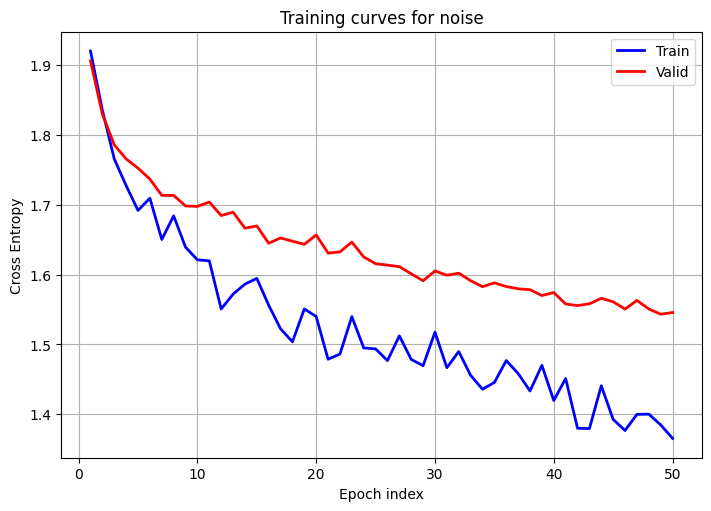

In [19]:
epochs = range(1,n_epoch+1)
#epochs = range(1,20)
train_loss = [i.detach().cpu() for i in train_loss]
valid_loss = [i.detach().cpu() for i in valid_loss]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,5),layout="constrained")
ax.plot(epochs,train_loss,linewidth=2,color="b",label='Train')
ax.plot(epochs,valid_loss,linewidth=2,color="r",label='Valid')
ax.grid()

ax.legend()

ax.set_xlabel("Epoch index")
ax.set_ylabel("Cross Entropy")
ax.set_title("Training curves for noise")

plt.show()

fig.savefig("train_noise_detection.png",dpi=300)

In [ ]:
dataset_music = 

In [7]:
import matplotlib.pyplot as plt

In [8]:
test_loader= DataLoader(dataset_test, batch_size=128, shuffle=False,num_workers=10)

In [7]:
"test"

'test'

In [9]:
ckpt = torch.load("./probes/sparse_noise_probe_256_mean.pt")
print(ckpt)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classif_probe = LinProbe(input_size=256,output_size=10,agreg='mean')
classif_probe.load_state_dict(ckpt)
classif_probe.to(device)
model.to(device)

OrderedDict([('probe.0.weight', tensor([[-0.0929,  0.0097, -0.0972,  ..., -0.4526, -0.0676,  0.0435],
        [ 0.1112, -0.0763, -0.0078,  ..., -0.0510, -0.0784, -0.1012],
        [ 0.0814, -0.0046,  0.1233,  ...,  0.2474,  0.0383, -0.0339],
        ...,
        [-0.1830, -0.0048,  0.0616,  ..., -0.3441,  0.0012,  0.0025],
        [ 0.2958, -0.0078, -0.0259,  ..., -0.1820, -0.2771,  0.0383],
        [-0.0039, -0.0292,  0.0407,  ...,  0.6060, -0.0634, -0.1575]],
       device='cuda:0')), ('probe.0.bias', tensor([-0.0244,  0.0274, -0.0437, -0.1953,  0.3059,  0.1295,  0.0223,  0.0176,
        -0.0612, -0.1477], device='cuda:0'))])


MASNMF(
  (spec_feat): SpecFeat(
    (spec): Spectrogram()
  )
  (wavlm): WavLM_Feats(
    (feature_extract): UpstreamExpert(
      (model): WavLM(
        (feature_extractor): ConvFeatureExtractionModel(
          (conv_layers): ModuleList(
            (0): Sequential(
              (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
              (1): Dropout(p=0.0, inplace=False)
              (2): Sequential(
                (0): TransposeLast()
                (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
                (2): TransposeLast()
              )
              (3): GELU()
            )
            (1): Sequential(
              (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
              (1): Dropout(p=0.0, inplace=False)
              (2): Sequential(
                (0): TransposeLast()
                (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
                (2): TransposeLast()
              )
     

In [10]:
pred = []
lab = []
model.to(device)
classif_probe.to(device)
for batch_idx, (data,label) in enumerate(tqdm.tqdm(test_loader)):    

    with torch.no_grad():
        feat = model.wavlm(data.to(device))
        emb = model.emb_transform(feat)
        lab.extend(label.detach().cpu().numpy())
        
        logits = classif_probe(emb.permute(0,2,1))
        #print(logits.shape)
        pred.extend(logits.argmax(dim=-1).detach().cpu().numpy())

        

100%|██████████| 13/13 [00:30<00:00,  2.31s/it]


In [12]:
from torchmetrics import F1Score,Accuracy,ConfusionMatrix,Recall
nclasses = 10
f1 = F1Score(task="multiclass",num_classes=nclasses,average="macro")
recall = Recall(task="multiclass",num_classes=nclasses,average="macro")
acc = Accuracy(task='multiclass',num_classes=nclasses)
conf = ConfusionMatrix(task='multiclass',num_classes=nclasses)
ecp = ExpectedCost(task="multiclass",num_classes=nclasses)

In [13]:
tpred = torch.from_numpy(np.array(pred))
tlabel = torch.from_numpy(np.array(lab))

In [14]:
import numpy as np
from expected_cost import ec
#print("0 Male, 1 Female")

print("Acc =",acc(tpred,tlabel))
print("F1score =",f1(tpred,tlabel))
print("UAR =",recall(tpred,tlabel))
#print("F1score Male =",f1((tpred*-1)+1,(tlabel*-1)+1))
#print("Confusion = ",conf(tpred,tlabel))
#print("\nCUSTOM EC")
print("Expected cost",ecp(tpred,tlabel))
print("Acc from EC",1-ecp(tpred,tlabel))


Acc = tensor(0.6140)
F1score = tensor(0.6125)
UAR = tensor(0.6068)
Expected cost tensor(0.3860)
Acc from EC tensor(0.6140)


In [18]:
classes = ['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']

<Axes: >

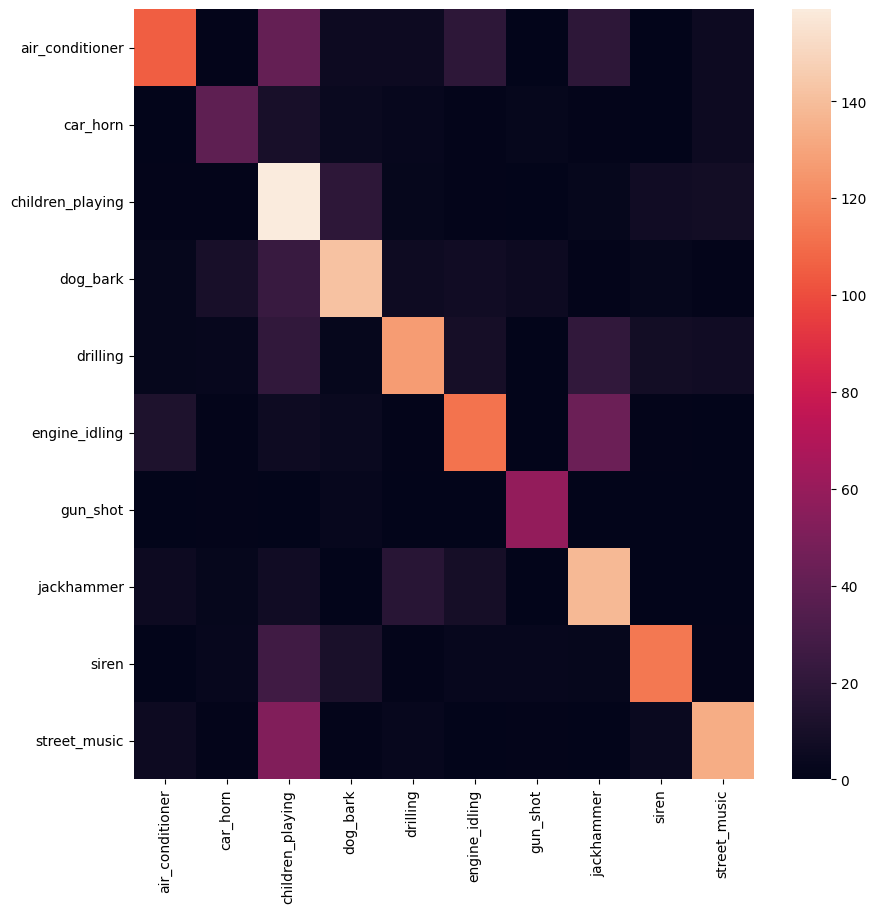

In [19]:
import seaborn as sn
plt.figure(figsize=(10,10))
sn.heatmap(conf(tpred,tlabel),xticklabels=classes,yticklabels=classes)

torch.Size([512])


<Axes: >

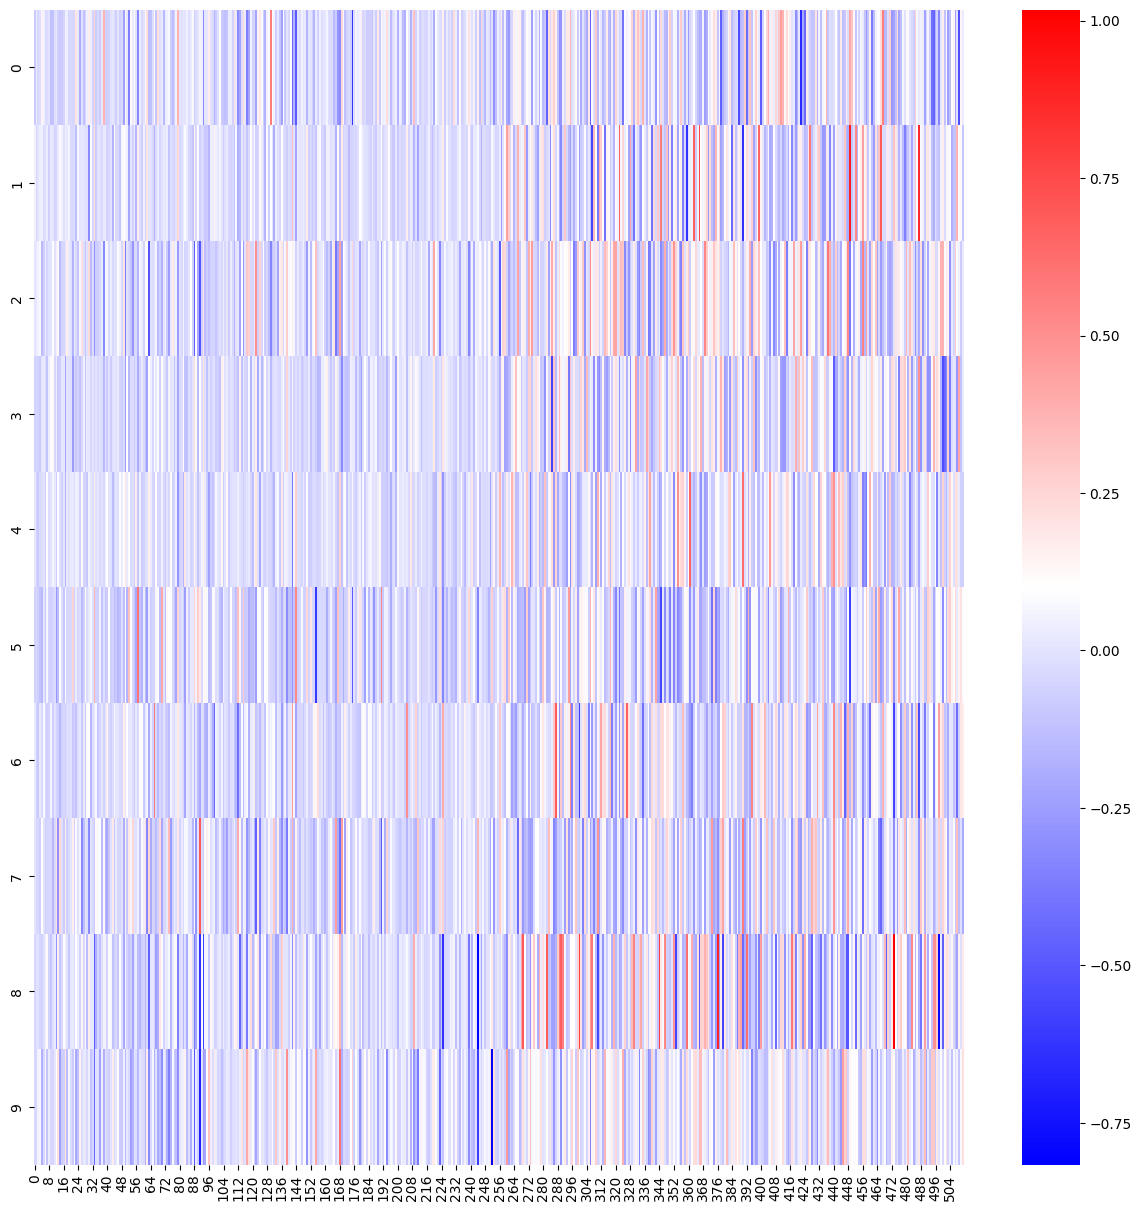

In [20]:
plt.figure(figsize=(15,15))
print(ckpt['probe.0.weight'].cpu()[0].shape)

sn.heatmap(ckpt['probe.0.weight'].cpu(),cmap='bwr')